# Tarea 4

* Sofía Cruz T. (**@cutsof**)
* Daniel Martínez U. (**@danmarurr**)

**Envío del PR inicial:** lunes 26 de septiembre

**Aceptación del PR:** lunes 10 de octubre

In [1]:
#Primero: cargamos toda la paquetería que usaremos
# Usaremos PyPlot ya que al parecer Julia 0.5 tiene problemas con Plots
using PyPlot, LsqFit, Roots,Polynomials
include("AutomDiff_V2.jl")
import AD: Dual, xdual

In [2]:
#Modelo para el ajuste de datos
model1(x, p) = p[1]*x + p[2]

model1 (generic function with 1 method)

**Ejercicio 0:** Velocidad de convergencia

El objetivo de este ejercicio es relacionar, la velocidad de convergencia con que un punto fijo (o una órbita periódica, en el caso de los dos últimos incisos) atraen a puntos suficientemente cercanos, con la derivada del mapeo en el punto fijo (o ciclo periódico). La idea es, entonces, calcular primero el punto fijo y, después, medir cómo la distancia de los iterados sucesivos (de una condición inicial $x_0$) al punto fijo se comporta en el tiempo, para los siguientes mapeos:

- $F(x) = x^2+0.25$

- $F(x) = 3x(1-x)$

- $F(x) = \exp(x-1)$

- $F(x) = x^2 - 1.25$

- $F(x) = \exp(1 - x)$

  Deberán resolver algunas cosas intermedias. Por ejemplo, ¿qué tanto deben acercarse al punto fijo, a fin de evitar ruido numérico? ¿Qué hay que hacer en el caso en que el punto sea neutral (ni atractivo ni repulsivo)?

  En los dos últimos incisos, el interés es en los ciclos de periodo 2.

### Solución

Para cada $F(x)$ encontraremos los puntos fijos correspondientes usando la paquetería `roots`, posteriormente averiguaremos que tanto debemos que tanto debemos acercarnos al punto fijo.

In [3]:
#Definimos las funciones que emplearemos
F1(x) = x^2 + 0.25
F2(x) = 3x*(1 - x)
F3(x) = exp(x - 1)
F4(x) = x^2 - 1.25
F5(x) = exp(1 - x)

#Ahora implementareos una función que calcule los puntos fijos de una determinada F(x)

function puntofijo(F::Function, ran)
    rf = fzeros(x -> (F(x) - x) , ran)
    return rf
end

#Implementamos el método de Newton para buscar los ceros

function newton1D{T<:Real}(f::Function, adiv::T, tol = 1e-10)
    x0 = xdual(adiv)
    fx = f(x0)
    count = 0
    while abs(fx.fun) > tol
        count += 1
        it = x0.fun - fx.fun/fx.der
        x0 = xdual(it)
        fx = f(x0)
        if count == 1000
            break
        end
    end
    return x0.fun
end

"""
`quadratic(a, b, c)` es una función `type-stable` que resuelve una ecuación de segundo grado con coeficientes 
reales: donde `a`es el coeficiente cuadrático, `b` el coeficiente lineal y `c` el coeficiente independiente, dado
a que el algoritmo emplea la función `sqrt` (que en general devuelve un valor del tipo `Float64` si el argumento de 
dicha función es un número `Real` se requiere que los argumentos `a`, `b` y `c` sean del tipo `Float64`
"""
function quadratic{T<:Real}(a::T, b::T, c::T)
    disc = b^2 - 4*a*c #Calculamos el valor del discriminante
    @assert a != 0 "Tu ecuación no es de segundo grado, revisa los argumentos.", disc < 0 
    "La ecuación tiene soluciones complejas, no es posible resolver la ecuación."
    resuelve_cuad(a,b,c, disc)
end

function resuelve_cuad(a, b, c, disc) #El algoritmo para encontrar las raíces
    sq = sqrt(disc)
    x1 = (-b+sq)/(2a)
    x2 = (-b-sq)/(2a)
    if x1 == x2
        raices = Float64[x1]
    else
        raices = typeof(x1)[x1,x2]
    end
    return raices
end

resuelve_cuad (generic function with 1 method)

Para las funciones $F_1$ y $F_2$ podemos calcular los puntos fijos de forma sencilla usando la fórmula general, pues son polinomios de segundo grado:

In [85]:
r1 = quadratic(1.0, -1.0, 0.25)

1-element Array{Float64,1}:
 0.5

In [5]:
r2 = quadratic(-3.0, 2.0, 0.0)

2-element Array{Float64,1}:
 -0.0     
  0.666667

Para $F_3$ es claro que el único punto fijo es $x_3 = 1$. Ahora, para $F_4$ sabemos que los puntos fijos de orden 1 también lo son de orden 2, entonces de $F_4^2(x) -x$, descartaremos las raíces que se obtengan de $F_4(x) -x$

In [6]:
#Punto fijo de F3
r3 = puntofijo(F3, Float64[-1, 1])

1-element Array{Float64,1}:
 1.0

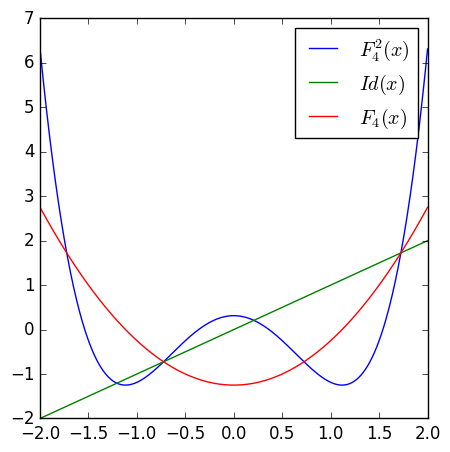

In [7]:
figure(figsize =(5,5))
ran1 = -2:1/128:2
m1 = map(x -> F4(F4(x)), ran1)
m2 = map(F4, ran1)
plot(ran1, m1, label = L"F_4^2(x)")
plot(ran1, ran1, label = L"Id(x)")
plot(ran1, m2, label = L"F_4(x)")
legend(loc = "auto")
show()

In [8]:
r41 = puntofijo(x -> F4(F4(x)), [-2,2])

4-element Array{Real,1}:
 -1.20711 
 -0.724745
  0.207107
  1.72474 

In [9]:
r4 = Float64[r41[1], r41[3]]

2-element Array{Float64,1}:
 -1.20711 
  0.207107

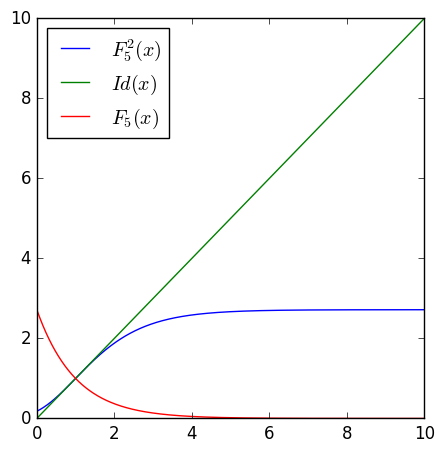

In [10]:
figure(figsize =(5,5))
ran1 = 0:1/128:10
m1 = map(x -> F5(F5(x)), ran1)
m2 = map(F5, ran1)
plot(ran1, m1, label = L"F_5^2(x)")
plot(ran1, ran1, label = L"Id(x)")
plot(ran1, m2, label = L"F_5(x)")
legend(loc = "auto")
show()

In [11]:
r5 = puntofijo(x -> F5(F5(x)), Float64[-1, 1])

1-element Array{Float64,1}:
 1.0

In [12]:
#Ahora definamos una función que dado un x0 calcule la distancia entre las iteraciones y los puntos fijos
function sensibility{T<:Real, S<:Real}(F::Function, x0::T, pfijos::Array{S,1}, n = 1000)
    ℓ = length(pfijos)
    distancia = zeros(Float64, n, ℓ)
    for j in 1:ℓ
        pf = pfijos[j]
        it = copy(x0)
        for i in 1:n
            it = F(it)
            #@show it
            distancia[i, j] = abs(it - pf)
        end
    end
    return distancia
end
    

sensibility (generic function with 2 methods)

### Para $F_1$

Dado a que $F'_1(0.5) = 1$ tenemos que el punto fijo no es atractor ni repulsor, pero intuitivamente podríamos probar con valores $x_0$ tales que $F'_1(x_0) < 1$, con $x_0$ cercano a 0.5 para observar un comportamiento atractor:

In [13]:
pf1 = xdual(0.5)
F1(pf1)

AD.Dual{Float64}(0.5,1.0)

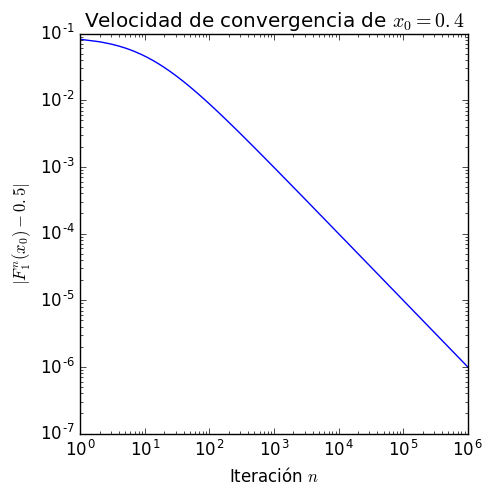

In [14]:
#Probemos primero con un punto x0 < 0.5
figure(figsize = (5, 5))
gr1 = sensibility(F1, 0.4, r1, 1000000);
d1 = reshape(gr1, 1000000)
loglog(d1)
#yscale("log")
title(L"Velocidad de convergencia de $x_0 = 0.4$")
xlabel(L"Iteración $n$")
ylabel(L"|F_1^n(x_0) - 0.5|")
show()

Para calcular la velocidad de convergencia, podemos hacer una regresión lineal con los logarítmos de los datos que tenemos:

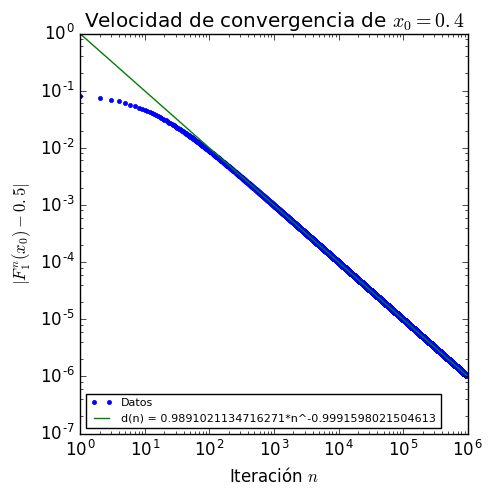

In [15]:
figure(figsize = (5,5))
dom1 = collect(1:1000000)
a1, b1 = linreg(log(dom1), log(d1))
ran1 = Float64[exp(a1)*x^b1 for x in dom1]
loglog(d1, ".", label = "Datos")
loglog(dom1, ran1, label = "v(n) = $(exp(a1))*n^$b1")
legend(fontsize = 8, loc = "auto")
title(L"Velocidad de convergencia de $x_0 = 0.4$")
xlabel(L"Iteración $n$")
ylabel(L"|F_1^n(x_0) - 0.5|")
show()

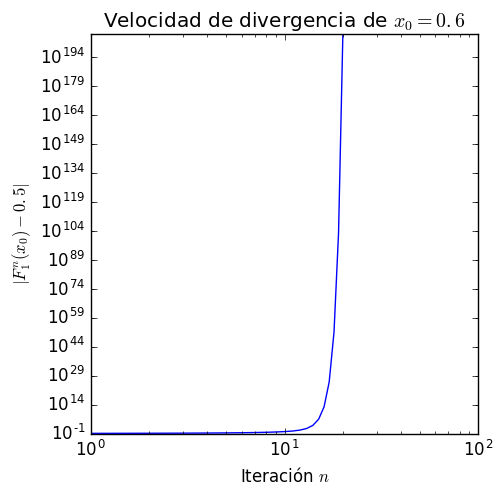

In [16]:
#Probemos ahora con un punto x0 > 0.5, para corroborar que para este valor, el punto fijo tiene comportamiento
#repulsor
figure(figsize = (5, 5))
gr1 = sensibility(F1, 0.6, r1, 100);
loglog(reshape(gr1, 100))
title(L"Velocidad de divergencia de $x_0 = 0.6$")
xlabel(L"Iteración $n$")
ylabel(L"|F_1^n(x_0) - 0.5|")
show()

Con lo anterior, podemos concluir la que velocidad de convergencia para el punto fijo de $F_1$ va como $v(n) \approx 1/n$.

### Para $F_2$

In [17]:
der2 = Float64[]

for j in r2
    x0 = xdual(j)
    push!(der2, F2(x0).der)
end
r2, der2

([-0.0,0.666667],[3.0,-1.0])

Para $F2$ tenemos que uno de los puntos fijos es atractor ($2/3$) y el otro es repulsor, tratemos con dos valores cercanos a $2/3$: por la derecha y por la izquierda.

In [18]:
figure(figsize = (5, 5))
gr1 = sensibility(F2, 0.5, r2, 1000000)
d2 = reshape(gr1[:,2],1000000)
dom2 = collect(1:1000000)
#loglog(dom2, d2)
fit = curve_fit(model1, log(dom2), log(d2), [5.0, 5.0])
b2, a2 = fit.param
ran2 = Float64[exp(a2)*x^b2 for x in dom2];

4.815394481060753 (predicted_residual) >
4.815394481060748 (residual) + 8.881784197001252e-16 (eps)


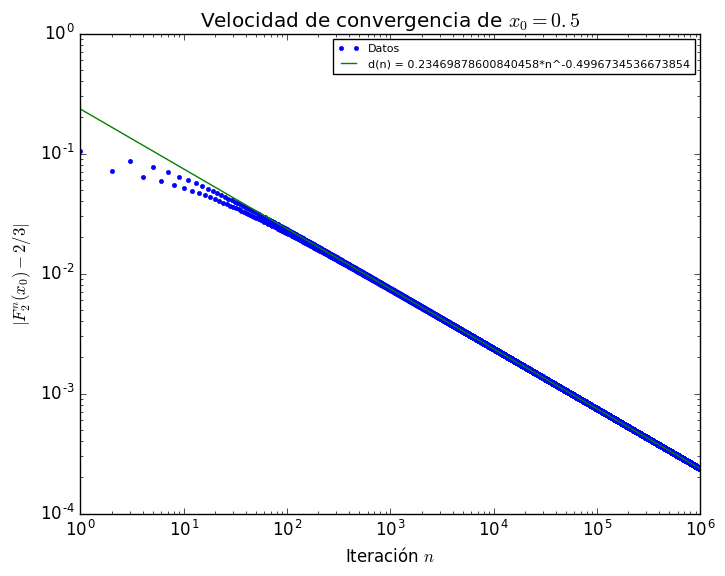

In [20]:
loglog(d2, ".", label = "Datos")
loglog(dom2, ran2, label = "v(n) = $(exp(a2))*n^$b2")
legend(fontsize = 8, loc = "auto")
title(L"Velocidad de convergencia de $x_0 = 0.5$")
xlabel(L"Iteración $n$")
ylabel(L"|F_2^n(x_0) - 2/3|")
show()

In [21]:
figure(figsize = (5, 5))
gr1 = sensibility(F2, 0.75, r2, 1000000)
d2 = reshape(gr1[:,2],1000000)
dom2 = collect(1:1000000)
#loglog(dom2, d2)
fit = curve_fit(model1, log(dom2), log(d2), [5.0, 5.0])
b2, a2 = fit.param
ran2 = Float64[exp(a2)*x^b2 for x in dom2];

5.251438860286394 (predicted_residual) >
5.251438860286388 (residual) + 8.881784197001252e-16 (eps)


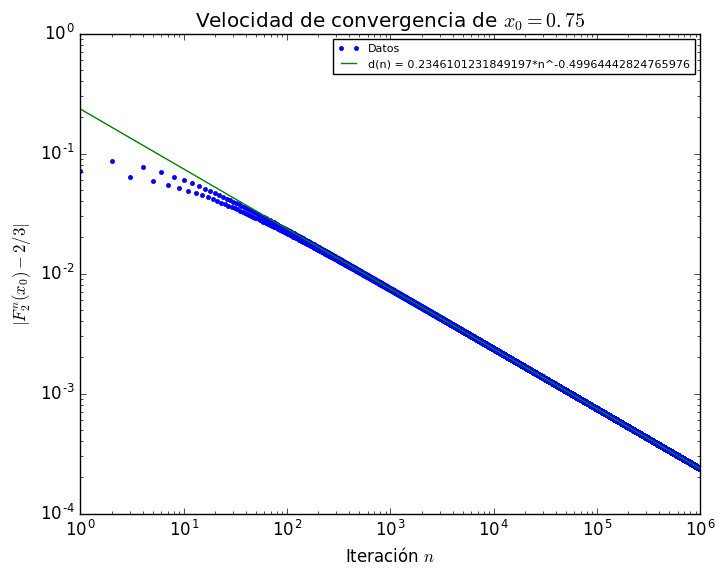

In [22]:
loglog(d2, ".", label = "Datos")
loglog(dom2, ran2, label = "v(n) = $(exp(a2))*n^$b2")
legend(fontsize = 8, loc = "auto")
title(L"Velocidad de convergencia de $x_0 = 0.75$")
xlabel(L"Iteración $n$")
ylabel(L"|F_2^n(x_0) - 2/3|")
show()

En ambos caso puede notarse que la velocidad de convergencia va como $v(n) \approx 0.2345/\sqrt{n}$

### Para $F_3$

Dado a que $F'_3(1) = 1$ tendremos que proceder de la misma forma que en $F_1$:

In [23]:
#Primero para un valor a la izquierda del punto fijo
figure(figsize = (5, 5))
gr1 = sensibility(F3, 0.9, r3, 1000000)
d2 = reshape(gr1[:,1],1000000)
dom2 = collect(1:1000000)
fit = curve_fit(model1, log(dom2), log(d2), [5.0, 5.0])
b2, a2 = fit.param
ran2 = Float64[exp(a2)*x^b2 for x in dom2];

53.02299067673144 (predicted_residual) >
53.02299067673141 (residual) + 7.105427357601002e-15 (eps)


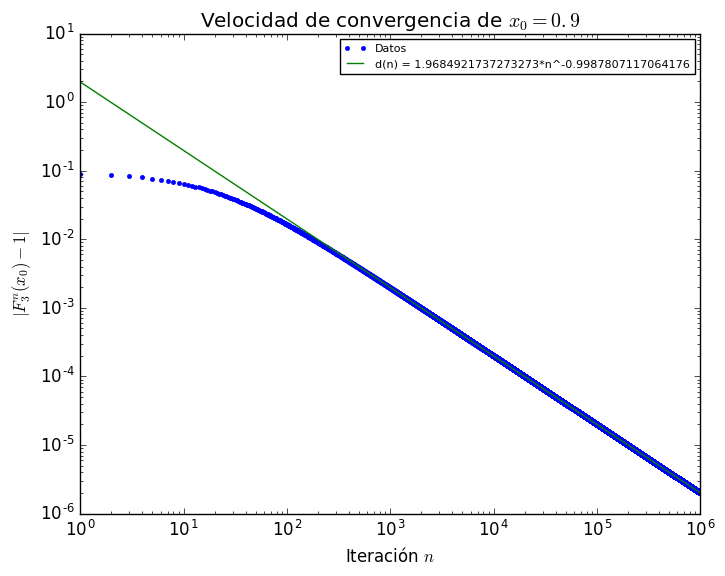

In [24]:
loglog(d2, ".", label = "Datos")
loglog(dom2, ran2, label = "v(n) = $(exp(a2))*n^$b2")
legend(fontsize = 8, loc = "auto")
title(L"Velocidad de convergencia de $x_0 = 0.9$")
xlabel(L"Iteración $n$")
ylabel(L"|F_3^n(x_0) - 1|")
show()

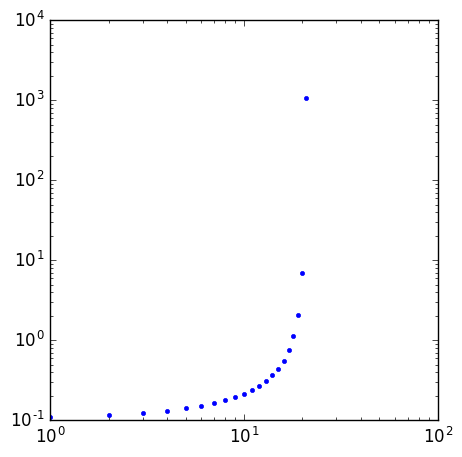

In [25]:
#Ahora a la derecha del punto fijo
figure(figsize = (5, 5))
gr1 = sensibility(F3, 1.1, r3, 1000000)
d2 = reshape(gr1[:,1],1000000)
dom2 = collect(1:1000000)
loglog(d2, ".", label = "Datos")
show()

Con esto vemos que para valores $x < 1$ la velocidad de convergencia va como $v(n) \approx 2/n$, mientras que para valores $x > 1$ diverge (esto porque para este caso $F_3'(x) > 1$).

## Para $F4$

In [26]:
F42(x) = F4(F4(x))

F42 (generic function with 1 method)

In [27]:
der4 = Float64[]

for j in r4
    x0 = xdual(j)
    push!(der4, F42(x0).der)
end
r4, der4

([-1.20711,0.207107],[-1.0,-1.0])

In [31]:
#Primero para un valor a la izquierda del punto fijo

gr1 = sensibility(F42, -1.3, r4, 1000000)
d2 = reshape(gr1[:,1],1000000)
dom2 = collect(1:1000000)
fit = curve_fit(model1, log(dom2), log(d2), [5.0, 5.0])
b2, a2 = fit.param
ran2 = Float64[exp(a2)*x^b2 for x in dom2];

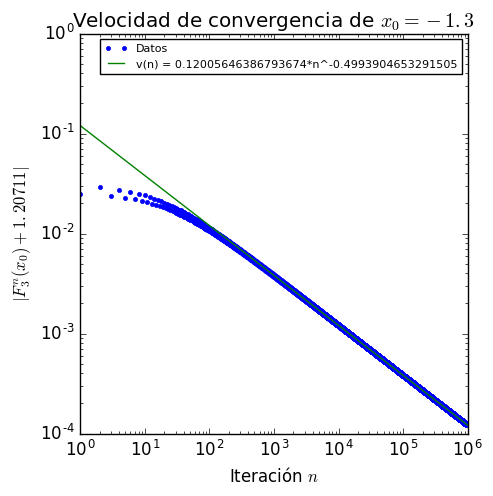

In [32]:
figure(figsize = (5, 5))
loglog(d2, ".", label = "Datos")
loglog(dom2, ran2, label = "v(n) = $(exp(a2))*n^$b2")
legend(fontsize = 8, loc = "auto")
title(L"Velocidad de convergencia de $x_0 = -1.3$")
xlabel(L"Iteración $n$")
ylabel(L"|F_3^n(x_0) + 1.20711|")
show()

In [33]:
#Primero para un valor a la derecha del punto fijo 2

gr1 = sensibility(F42, 0.3, r4, 1000000)
d2 = reshape(gr1[:,2],1000000)
dom2 = collect(1:1000000)
fit = curve_fit(model1, log(dom2), log(d2), [5.0, 5.0])
b2, a2 = fit.param
ran2 = Float64[exp(a2)*x^b2 for x in dom2];

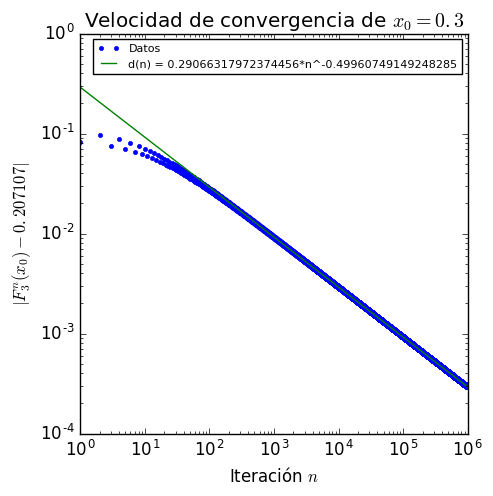

In [34]:
figure(figsize = (5, 5))
loglog(d2, ".", label = "Datos")
loglog(dom2, ran2, label = "d(n) = $(exp(a2))*n^$b2")
legend(fontsize = 8, loc = "auto")
title(L"Velocidad de convergencia de $x_0 = 0.3$")
xlabel(L"Iteración $n$")
ylabel(L"|F_3^n(x_0) - 0.207107|")
show()

Para ambos casos vemos que la velocidad de convergencia va como $v(n) = 0.3/\sqrt{n}$

## Para $F^2_5$

In [35]:
F52(x) = F5(F5(x))

F52 (generic function with 1 method)

In [36]:
der5 = Float64[]

for j in r5
    x0 = xdual(j)
    push!(der5, F52(x0).der)
end
r5, der5

([1.0],[1.0])

Justo como hemos observado en las funciones anteriores, usaremos valores tales que $(F_5^2(x))< 1$ para así asegurar que el converja al punto fijo

In [37]:
gr1 = sensibility(F52, 0.8, r5, 1000000)
d2 = reshape(gr1[:,1],1000000)
dom2 = collect(1:1000000)
fit = curve_fit(model1, log(dom2), log(d2), [5.0, 5.0])
b2, a2 = fit.param
ran2 = Float64[exp(a2)*x^b2 for x in dom2];

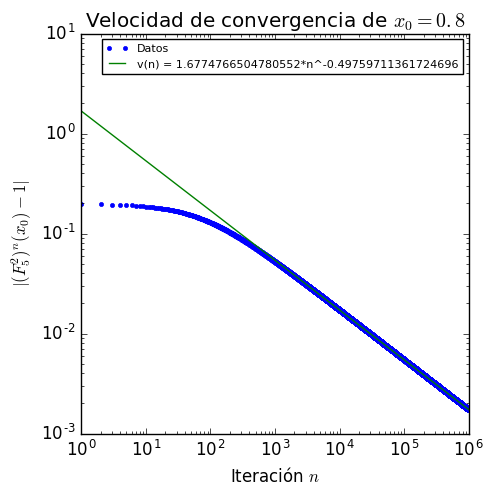

In [38]:
figure(figsize = (5, 5))
loglog(d2, ".", label = "Datos")
loglog(dom2, ran2, label = "v(n) = $(exp(a2))*n^$b2")
legend(fontsize = 8, loc = "auto")
title(L"Velocidad de convergencia de $x_0 = 0.8$")
xlabel(L"Iteración $n$")
ylabel(L"|(F_5^2)^n(x_0) - 1|")
show()

Concluimos que la velocidad de convergencia va como $v(n) 0 1.677/\sqrt{n}$

**Ejercicio 1:**

Llamemos $c_n$ el valor del parámetro $c$ donde ocurre la bifurcación de doblamiento de periodo para el mapeo $Q_c(x)$, donde la órbita de periodo $2^n$ nace. Es decir, tenemos que $c_0=1/4$ marca la aparición del atractor de periodo $2^0=1$, $c_1=-1/4$ corresponde a la aparición del atractor de periodo $2^1=2$, $c_2=-3/4$ a la aparición del atractor de periodo $2^2=4$, etc. 

A partir de estos valores y otros que calcularán (al menos deben encontrar $c_6$), definimos la secuencia: $\{f_0, f_1, f_2, \dots\}$, donde

\begin{equation}
f_n = \frac{c_n-c_{n+1}}{c_{n+1}-c_{n+2}} .
\end{equation}

La pregunta es, ¿a qué valor converge esta secuencia?, es decir, dar una estimación de $f_\infty$.



*Hint:* Para realizar este ejercicio deben calcular el atractor para varias valores de $c$, de tal manera que puedan aislar las órbitas de periodo $2^p$ y de ahí determinar varios valores $c_n$. Sin embargo, van a requerir suficiente cuidado para obtener una buena aproximación de $c_n$. 

Una opción, que tiene ciertos inconvenientes numéricos que también ciertas ventajas se basa en recordar/usar que las bifurcaciones de doblamiento de periodo ocurren cuando los puntos de la órbita de periodo $p$ se tornan en repulsores, es decir, $(Q_c^p)'(x)=-1$. Esta opción, entonces, involucra obtener los valores $c_n$ usando los polinomios $Q_c^p(x)$ y diferenciación automática.

In [63]:
"""
`iterado` realiza y guarda las primeras `n` iteraciones del punto x0 empleando el mapeo `F`
"""
function iterado(F::Function,x0::Float64,n::Int64)
    @assert n > -1 "n debe ser entero positivo"
    y = Float64[x0]
    x = x0
    for i in 1:n
        x=F(x)
        push!(y,x)
    end
    y
end

iterado

In [64]:
?iterado

search: isinteractive register_cmap pointer_to_array



`iterado` realiza y guarda las primeras `n` iteraciones del punto x0 empleando el mapeo `F`


In [65]:
"""
`Lyapunov` calcula el exponente de Lyapunov del mapeo `F` usando las iteraciones contenidas en el arreglo `y`
"""
function Lyapunov(y::Array, F::Function)
    n = length(y)
    l = 0
   # logval = Float64[]
    for i in 1:n
        x = abs((F(xdual(y[i]))).der)
        l = l + log(x)
       # push!(logval,x)
    end
    l/n#,logval
end

Lyapunov

In [66]:
"""
`mapeo_liap` obtiene los exponentes de Lyapunov para el mapeo cuadrático, usando los valores del rango `crange` y
un valor inicial `x0` y `n` iteraciones.
"""
function mapeo_liap(crange::FloatRange,x0::Float64,n::Int)
    map=Float64[]
    cmap = Float64[]
    for i in crange
        Qci(x) = Qc(x,i) 
        y = iterado(Qci,x0,n)
        l = Liaponov(y, Qci)
        if l <= 0   
          if abs(l)<Inf
           push!(map,l)      
          else
           push!(map,-10)       
          end
        else
          break
        end
    end
    
    for i in 1:length(map)
        push!(cmap,crange[i])
    end
    map,cmap
end

mapeo_liap

In [68]:
#Comprobamos que las implementaciones funcionan
Qc(x,c)=x^2+c
Qc1(x) = Qc(x,-1.23)
y=iterado(Qc1,1.0,10)


11-element Array{Float64,1}:
  1.0     
 -0.23    
 -1.1771  
  0.155564
 -1.2058  
  0.223953
 -1.17985 
  0.162034
 -1.20374 
  0.219002
 -1.18204 

In [69]:
crange = -(0.75-1/2^16):-1/2^16:-1.405
map,c = mapeo_liap(crange,Qc,1.0,10000);

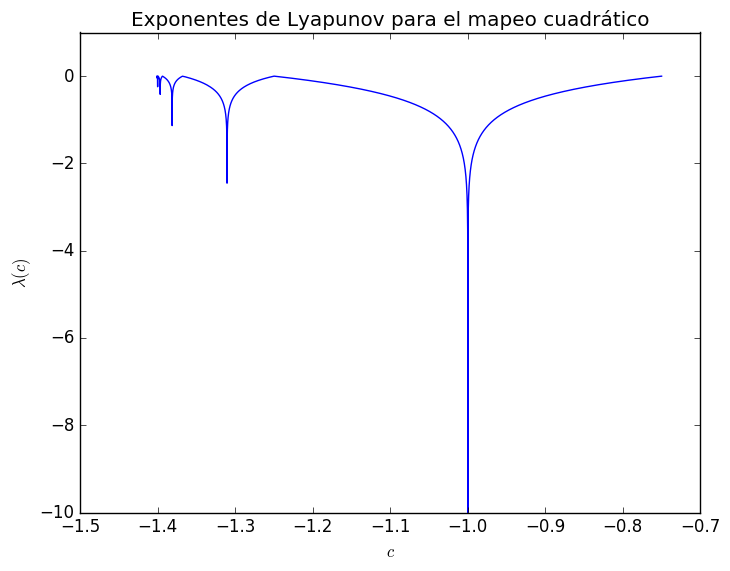

In [71]:
p = plot(c, map)
xlabel(L"c")
ylabel(L"\lambda(c)")
title("Exponentes de Lyapunov para el mapeo cuadrático")
ylim(-10, 1)
show()

In [72]:
"""
`mins` obtiene los valores de `c` para los cuales |lambda| es mínimo, usando la condición observada en la gráfica
de exponentes para el mapeo cuadrático.
"""
function mins(map::Array,crange::Array)
    n = length(map)
    c = Float64[]
    for i in 2:n-1       
        if (abs(map[i+1]) > abs(map[i]) < abs(map[i-1])) 
            push!(c,(crange[i]))
        end
        
    end
    return c
end

mins

In [73]:
cs = (mins(map,c))
cs = deleteat!(cs,4)

7-element Array{Float64,1}:
 -1.24995
 -1.36807
 -1.39404
 -1.39963
 -1.40083
 -1.40108
 -1.40114

In [74]:
"""
`feigen` calcula constante de Feigenbaum usando un arreglo de valores de c dadas.
"""
function feigen(cs::Array)
    f = Float64[]
    for i in 3:length(cs)
        fei=((cs[i-2])-(cs[i-1]))/((cs[i-1])-(cs[i]))
        push!(f,fei)
        end
    f
end


feigen

In [75]:
feigen(cs)

5-element Array{Float64,1}:
 4.54818
 4.65027
 4.63291
 4.9375 
 4.0    

Salvo los últimos dos valores, vemos que las constante tiende al valor $\delta = 4.669201...$ (consultado [aquí](https://en.wikipedia.org/wiki/Feigenbaum_constants))

**Ejercicio 2:**

Repitan el ejercicio anterior para el mapeo $S_c(x) = c \sin(x)$. ¿Cómo se comparan los valores obtenidos de $f_n$?

In [76]:
Sc(x,c)=c*sin(x)

Sc (generic function with 1 method)

In [77]:
crange = -0.0:-1/2^12:-3.0
smap,sc = mapeo_liap(crange,Sc,1.0,10000);

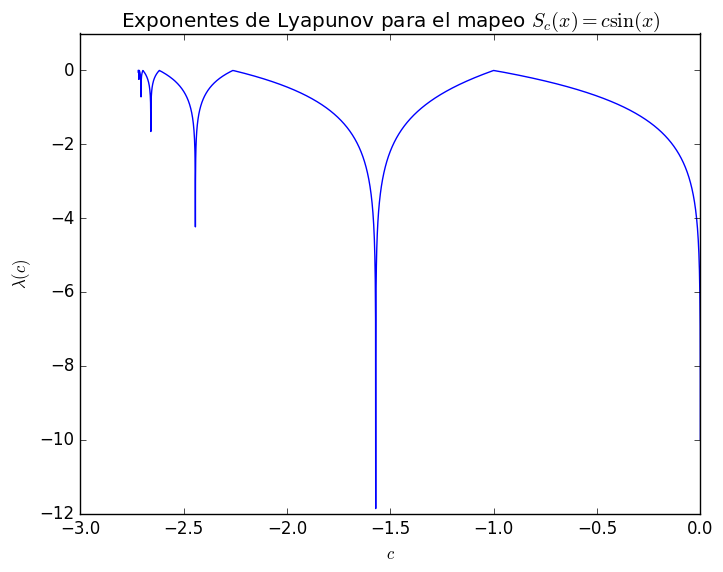

In [78]:
p = plot(sc, smap)
xlabel(L"c")
ylabel(L"\lambda(c)")
title(L"Exponentes de Lyapunov para el mapeo $S_c(x) = c\sin(x)$")
ylim(-12, 1)
show()

In [79]:
sc_mins = mins(smap,sc)

6-element Array{Float64,1}:
 -1.0    
 -2.26172
 -2.61768
 -2.69727
 -2.7146 
 -2.71826

In [80]:
feigen(sc_mins)

4-element Array{Float64,1}:
 3.54458
 4.47239
 4.59155
 4.73333

Notamos que el valor comienza a tender hacia $\delta = 4.669201...$, como era de esperarse (pues sabemos que la constante es universal)

**Ejercicio 3:**

Como se ve en la Fig. 1 (de [este](https://github.com/lbenet/2017-1_TSFisComp/blob/master/notas_clase/08_Mapeos1d-3.ipynb) notebook), $x=0$ pertenece a un ciclo de periodo $2^n$ para ciertos valores $C_n$ del parámetro. Dichos valores son *especiales*, ya que $x=0$ esté en el ciclo de periodo $2^n$ marca los llamados *ciclos superestable*, donde tenemos $(Q^{2^p}_{C_n})'(0)=0$.

¿A qué converge la secuencia $f_n$, definida ahora con los valores $C_n$.

De los $2^p$ puntos del ciclo de periodo $2^p$, es decir, $\{0, p_1, \dots p_{2^{n-1}}\,\}$ hay uno (distinto del 0) cuya distancia a 0 es menor; a ese punto lo identificamos como $d_n$. Calcular numéricamente a dónde converge la secuencia $d_n/d_{n+1}$.

In [81]:
"""
`mins` obtiene los valores de `c` para los cuales |lambda| es máximo, usando la condición observada en la gráfica
de exponentes para el mapeo cuadrático.
"""
function maxs(map::Array,crange::FloatRange)
    n = length(map)
    c = Float64[]
    for i in 2:n-1
        if (abs(map[i+1]) < abs(map[i]) > abs(map[i-1])) 
            push!(c,(crange[i]))
        end
    end
    c
end

maxs

In [82]:
#Empleando los 
cs1 = (maxs(map,c))

8-element Array{Float64,1}:
 -1.0    
 -1.3107 
 -1.38155
 -1.39694
 -1.39926
 -1.40025
 -1.40096
 -1.40111

In [83]:
feigen(cs1)

6-element Array{Float64,1}:
 4.38553
 4.60159
 6.63816
 2.33846
 1.41304
 4.6    

Los valores para éstas c's convergen a constante de Feigenbaum $\delta$

Obtención de $\frac{d_n}{d_{n+1}}$

In [90]:
"""
`DS` calcula los valores de la sucesión d_n para el mapeo cuadrático en el rango `cs1`
"""
function DS(cs1::FloatRange)
    dn = Float64[]
    for i in 1: length(cs1)
        d = minabs(deleteat!((iterado(x -> Qc(x,cs1[i]),0.0,2^(i-1))),1))
       
        push!(dn,d)
    end
    dn
end

DS

In [91]:
ds = DS(cs1)

8-element Array{Float64,1}:
 1.0        
 0.407234   
 0.163421   
 0.0653461  
 0.0168591  
 2.36222e-6 
 0.000136808
 0.000216859

In [92]:
function cociente(ds)
    f = Float64[]
    for i in 2:length(ds)
        fei=(ds[i-1]/ds[i])
        push!(f,fei)
        end
    f
end


cociente (generic function with 1 method)

In [93]:
cociente(ds)

7-element Array{Float64,1}:
    2.45559  
    2.49193  
    2.50085  
    3.87601  
 7136.97     
    0.0172667
    0.630859 

Al menos en los tres primeros valores, la sucesión converge a la segunda constante de Feigenbaum $\alpha = 2.502907875095892822$